In [50]:
import os
import nrrd

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

# https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
from scipy.stats import wilcoxon
from scipy.stats import shapiro
from scipy.stats import normaltest

from sklearn.preprocessing import StandardScaler

from ioutil import sample_paths

sns.set()
%matplotlib inline

# GTV reduction

In [2]:
path_orig_masks = './../../data_source/images/masks_nrrd'
path_red_masks = './../../data_source/images/masks_removed_broken_slices_ct_size'

path_to_files = sample_paths(path_orig_masks, path_red_masks, target_format='nrrd')

red_volume = []
for path_to_file in path_to_files:
    
    orig_mask, _ = nrrd.read(path_to_file['Image'])
    red_mask, _ = nrrd.read(path_to_file['Mask'])
    
    red_volume.append(np.sum(red_mask) / np.sum(orig_mask))

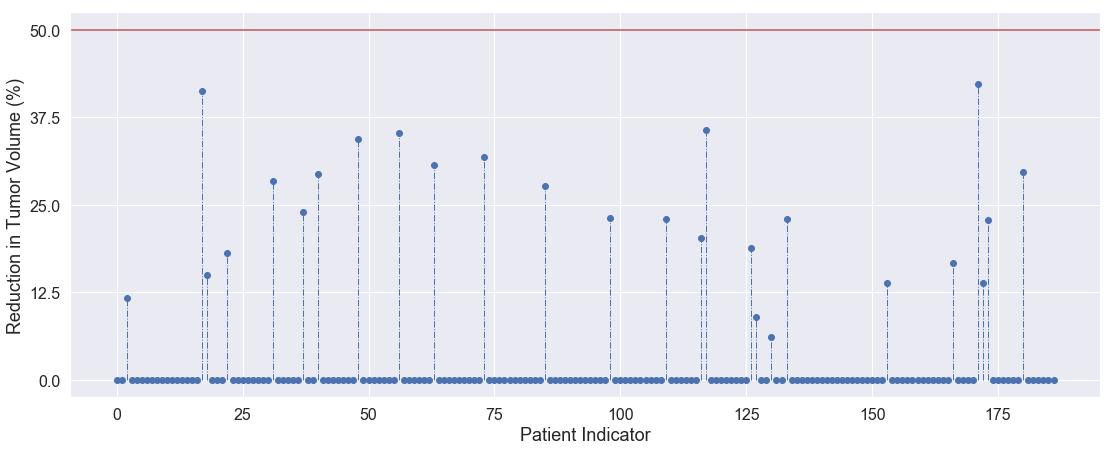

In [3]:
# The fraction of GTV removed by discarding damaged slices.
x_coords = np.arange(len(red_volume))

plt.figure(figsize=(15, 6))
sns.scatterplot(
    x_coords, 100 - (np.array(red_volume) * 100)
)
markerline, stemlines, baseline = plt.stem(
    x_coords, 100 - (np.array(red_volume) * 100), 
    linefmt='b-.', markerfmt='bo', bottom=0
)
plt.setp(stemlines, 'linewidth', 1)
plt.setp(baseline, 'linewidth', 0)


plt.axhline(y=50, c='r')
plt.tight_layout()
plt.xlabel('Patient Indicator', fontsize=18)
plt.ylabel('Reduction in Tumor Volume (%)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(np.linspace(0.0, 50, 5), np.linspace(0.0, 50, 5), fontsize=16)
plt.savefig(
    './../../figures/removing_damaged_slices/frac_gtv_removed.png', 
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)

# Load Data

In [4]:
def firstorder_texture(X, modal):
    
    if modal == 'CT':
        _CT = X.filter(regex='CT') 
        _CT_fs = _CT.filter(regex='firstorder')
        _CT_text = _CT.drop(_CT_fs.columns, axis=1)
        return _CT_fs, _CT_text
    
    elif modal == 'PET':
        _PET = X.filter(regex='PET')
        _PET_fs = _PET.filter(regex='firstorder')
        _PET_text = _PET.drop(_PET_fs.columns, axis=1)
        # Skip PET params.
        pet_params = ['PETparam_SUVpeak', 'PETparam_MTV', 'PETparam_TLG']
        _PET_text = _PET_text.drop(pet_params, axis=1)
        return _PET_fs, _PET_text

In [54]:
X_orig = pd.read_csv(
    './../../data_source/to_analysis/original_images/all_features_original_images.csv', index_col=0
)
X_red = pd.read_csv(
    './../../data_source/to_analysis/removed_broken_slices/all_features_removed_broken_slices.csv', index_col=0
)

scaler = StandardScaler()
X_orig_std = scaler.fit_transform(X_orig.values)
X_red_std = scaler.fit_transform(X_red.values)

X_orig = pd.DataFrame(X_orig_std, index=X_orig.index, columns=X_orig.columns)
X_red = pd.DataFrame(X_red_std, index=X_red.index, columns=X_red.columns)

X_orig.shape, X_red.shape

((198, 513), (187, 513))

In [55]:
X_orig.head()

,Age,Years Smoking,Naxogin Days,Sex_M,ICD-10_C02,ICD-10_C03,ICD-10_C04,ICD-10_C05,ICD-10_C06,ICD-10_C09,...,PET_original_ngtdm_Complexity_128bins,PET_original_ngtdm_Contrast_32bins,PET_original_ngtdm_Contrast_64bins,PET_original_ngtdm_Contrast_128bins,PET_original_ngtdm_Strength_32bins,PET_original_ngtdm_Strength_64bins,PET_original_ngtdm_Strength_128bins,PETparam_SUVpeak,PETparam_MTV,PETparam_TLG
2,0.072025,-1.058710,0.524778,0.581238,-0.205196,-0.071247,-0.124035,-0.143592,-0.071247,1.294479,...,2.577204,2.754401,2.755459,2.789221,2.937093,2.879729,2.803352,2.060020,-0.329664,0.074504
4,-1.380295,-0.860636,0.035617,-1.720465,-0.205196,-0.071247,-0.124035,-0.143592,-0.071247,1.294479,...,0.583118,1.486790,1.376327,1.281489,2.913643,3.108692,3.252446,0.852806,-0.656158,-0.414287
5,-0.804538,-1.058710,0.769359,-1.720465,-0.205196,-0.071247,-0.124035,-0.143592,-0.071247,1.294479,...,0.208149,0.671695,0.709423,0.686237,0.593658,0.576022,0.596318,0.695607,-0.284523,-0.152199
8,-0.744814,-0.299533,-2.654773,0.581238,-0.205196,-0.071247,-0.124035,-0.143592,-0.071247,-0.772512,...,-0.248200,-0.947975,-0.861124,-0.825409,-0.651467,-0.662790,-0.669500,-0.061240,1.274239,0.547023
10,0.191110,-1.058710,0.198671,0.581238,-0.205196,-0.071247,-0.124035,-0.143592,-0.071247,-0.772512,...,-0.637823,-0.656526,-0.709871,-0.678416,-0.634355,-0.617840,-0.632111,-0.691116,-0.439891,-0.469731


In [56]:
X_red.head()

,Age,Years Smoking,Naxogin Days,Sex_M,ICD-10_C02,ICD-10_C03,ICD-10_C04,ICD-10_C05,ICD-10_C06,ICD-10_C09,...,PET_original_ngtdm_Complexity_128bins,PET_original_ngtdm_Contrast_32bins,PET_original_ngtdm_Contrast_64bins,PET_original_ngtdm_Contrast_128bins,PET_original_ngtdm_Strength_32bins,PET_original_ngtdm_Strength_64bins,PET_original_ngtdm_Strength_128bins,PETparam_SUVpeak,PETparam_MTV,PETparam_TLG
2,0.071574,-1.070577,0.515204,0.571175,-0.197203,-0.073324,-0.103975,-0.147844,-0.073324,1.338299,...,-0.815942,-0.504513,-0.515838,-0.527361,-0.588796,-0.557705,-0.600468,2.039895,-0.309209,0.081983
4,-1.375116,-0.871748,0.025946,-1.750776,-0.197203,-0.073324,-0.103975,-0.147844,-0.073324,1.338299,...,-0.473409,0.120517,0.036902,-0.049049,-0.588212,-0.570712,-0.524029,0.855427,-0.632064,-0.396744
5,-0.801591,-1.070577,0.759834,-1.750776,-0.197203,-0.073324,-0.103975,-0.147844,-0.073324,1.338299,...,-0.319801,-0.336101,-0.349742,-0.354325,-0.423394,-0.374558,-0.409674,0.701190,-0.264570,-0.140052
8,-0.742098,-0.308508,-2.664979,0.571175,-0.197203,-0.073324,-0.103975,-0.147844,-0.073324,-0.747217,...,0.600281,-0.435375,-0.459789,-0.485642,-0.598673,-0.526648,-0.467589,-0.041397,1.276826,0.544773
10,0.190197,-1.070577,0.189032,0.571175,-0.197203,-0.073324,-0.103975,-0.147844,-0.073324,-0.747217,...,-0.620574,-0.390565,-0.430536,-0.439787,-0.424611,-0.360510,-0.350047,-0.659405,-0.418207,-0.451046


In [57]:
CT_orig_fs, CT_orig_text = firstorder_texture(X_orig, modal='CT')
CT_red_fs, CT_red_text = firstorder_texture(X_red, modal='CT')

PET_red_fs, PET_red_text = firstorder_texture(X_red, modal='PET')
PET_orig_fs, PET_orig_text = firstorder_texture(X_orig, modal='PET')

In [58]:
np.sum(np.isin(CT_orig_fs.columns, CT_red_fs.columns)) / max(len(CT_orig_fs.columns), len(CT_red_fs.columns))

1.0

In [59]:
np.sum(np.isin(CT_orig_text.columns, CT_red_text.columns)) / max(len(CT_orig_text.columns), len(CT_red_text.columns))

1.0

In [60]:
np.sum(np.isin(PET_orig_fs.columns, PET_red_fs.columns)) / max(len(PET_orig_fs.columns), len(PET_red_fs.columns))

1.0

In [61]:
np.sum(np.isin(PET_orig_text.columns, PET_red_text.columns)) / max(len(PET_orig_text.columns), len(PET_red_text.columns))

1.0

# Features Changed From Removing Slices

In [62]:
diff_CT_fs = CT_orig_fs.loc[CT_red_fs.index, :] - CT_red_fs
diff_CT_text = CT_orig_text.loc[CT_red_text.index, :] - CT_red_text

diff_PET_fs = PET_orig_fs.loc[PET_red_fs.index, :] - PET_red_fs
diff_PET_text = PET_orig_text.loc[PET_red_text.index, :] - PET_red_text

sum(diff_CT_fs.sum()), sum(diff_CT_text.sum()), sum(diff_PET_fs.sum()), sum(diff_PET_text.sum()), 

(-191.64289898817728,
 -513.5374198394691,
 -12.811679882002402,
 -117.06110312421617)

In [63]:
sum(diff_CT_fs.isnull().sum()), sum(diff_CT_text.isnull().sum())

(0, 0)

In [64]:
sum(diff_PET_fs.isnull().sum()), sum(diff_PET_text.isnull().sum())

(0, 0)

# Test for Normality

In [99]:
# https://pythonfordatascience.org/paired-samples-t-test-python/
# https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
def norm_test(features, alpha=0.05):
    
    _, num_cols = np.shape(features)
    
    norm, not_norm = {}, {}
    for col in features:
        # The D’Agostino’s K^2 test calculates summary statistics from the data, 
        # namely kurtosis and skewness, to determine if the data distribution departs 
        # from the normal distribution.
        _, k2_p_value = normaltest(features.loc[:, col])
        # The Shapiro-Wilk test evaluates a data sample and quantifies how likely it is 
        # that the data was drawn from a Gaussian distribution.
        _, sw_p_value = shapiro(features.loc[:, col])
        # Bonferroni correction.
        k2_p_value = k2_p_value / num_cols
        sw_p_value = sw_p_value / num_cols
        
        # A failure of one normality test means that your data is not normal. 
        if k2_p_value > alpha and sw_p_value > alpha:
            # Sample looks Gaussian (fail to reject H0).
            norm[col] = np.max([k2_p_value, sw_p_value])
        else:
            # Sample does not look Gaussian (reject H0).
            not_norm[col] = np.min([k2_p_value, sw_p_value])
                
    return norm, not_norm

In [100]:
# NOTE: Testing for normality needs to be conducted on the differences 
# between the two conditions, not the raw values of each condition itself.
CT_fs_norm, CT_fs_not_norm = norm_test(diff_CT_fs)
CT_fs_norm

{}

In [143]:
CT_text_norm, CT_text_not_norm = norm_test(diff_CT_text)
CT_text_norm

{}

In [102]:
PET_fs_norm, PET_fs_not_norm = norm_test(diff_PET_fs)
PET_fs_norm

{}

In [103]:
PET_text_norm, PET_text_not_norm = norm_test(diff_PET_text)
PET_text_norm

{}

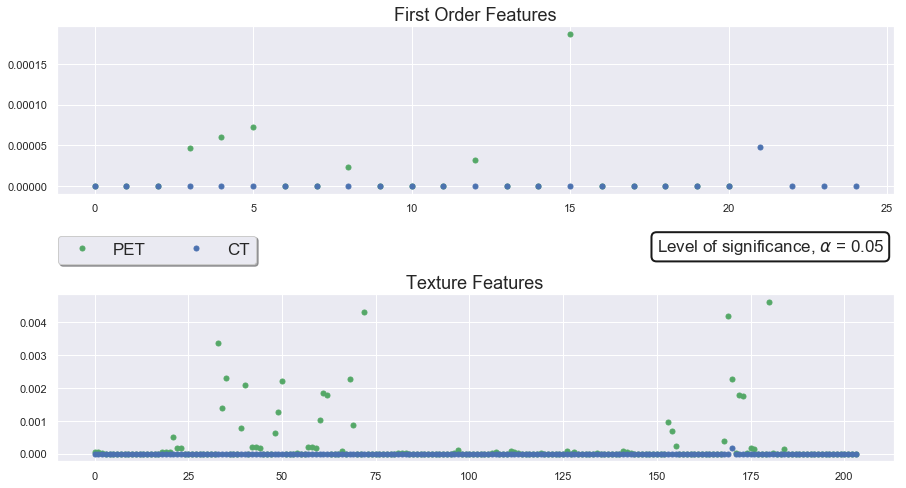

In [141]:
markersize = 5

fig, axes = plt.subplots(nrows=2, figsize=(15, 8))

axes[0].plot(PET_fs_not_norm.values(), 'go', markersize=markersize, label='PET')
axes[0].plot(CT_fs_not_norm.values(), 'bo', markersize=markersize, label='CT')
axes[0].set_title('First Order Features', fontsize=18)

axes[1].plot(PET_text_not_norm.values(), 'go', markersize=markersize, label='PET')
axes[1].plot(CT_text_not_norm.values(), 'bo', markersize=markersize, label='CT')
axes[1].set_title('Texture Features', fontsize=18)

axes[0].legend(
    loc='upper center', bbox_to_anchor=(0.12, -0.2), fancybox=True, shadow=True, ncol=2,
    fontsize=17
)
axes[1].annotate(
    r'Level of significance, $\alpha$ = 0.05', 
    xy=(600, 205),
    xycoords='axes points',
    size=17, 
    ha='left', 
    va='bottom',
    bbox=dict(boxstyle='round', fc='w', ec='k', lw=2)
)

#for axis in axes.ravel():
#    axis.set_xticklabels(fontsize=16)
#    axis.set_yticklabels(fontsize=16)

plt.subplots_adjust(hspace=0.6)
plt.savefig(
    './../../figures/removing_damaged_slices/bonfer_corr_norm_test.png',
    bbox_inches='tight',
    dpi=100, 
)

# Statistical Difference Test

**Notes**
* In applied machine learning, we often need to determine whether two data samples have the same or different distributions.
* We can answer this question using statistical significance tests that can quantify the likelihood that the samples have the same distribution.
* If the data does not have the familiar Gaussian distribution, we must resort to nonparametric version of the significance tests.
* These tests operate in a similar manner, but are distribution free, requiring that real valued data be first transformed into rank data before the test can be performed.

**Hypothesis**
* p <= alpha: reject H0, different distribution.
* p > alpha: fail to reject H0, same distribution.


**Wilcoxon Signed-Rank Test**

* The data samples are paired.
* The Wilcoxon signed ranks test is a nonparametric statistical procedure for comparing two samples that are paired, or related. The parametric equivalent to the Wilcoxon signed ranks test goes by names such as the Student’s t-test, t-test for matched pairs, t-test for paired samples, or t-test for dependent samples.
* The default assumption for the test, the null hypothesis, is that the two samples have the same distribution.
    - Fail to Reject H0: Sample distributions are equal.
    - Reject H0: Sample distributions are not equal.

**REF:** Pages 38-39, Nonparametric Statistics for Non-Statisticians: A Step-by-Step Approach, 2009.



In [150]:
def format_feature_labels(labels):
    """Process raw feature labels."""
    prep_labels = []
    for label in labels:

        comps = label.split('_')
        if len(comps) == 1:
            prep_labels.append(label.title())
        elif len(comps) == 2:
            new_label = f'{comps[0]}: {comps[1]}'
            prep_labels.append(new_label)
        elif len(comps) == 3:
            filter_type, feature_type, name = comps
            if len(name) > 15:
                new_label = '{}'.format(name)
            else:
                new_label = '{}'.format(name)
            prep_labels.append(new_label)
        elif len(comps) == 4:
            image_type, filter_type, feature_type, name = comps
            if len(name) > 15:
                new_label = f'{name}'
            else:
                new_label = f'{name}'
            prep_labels.append(new_label)
        elif len(comps) == 5:
            image_type, _, _, name, _ = comps
            if len(name) > 15:
                new_label = f'{name}'
            else:
                new_label = f'{name}'
            prep_labels.append(new_label)
        else:
            raise ValueError('Label more than 5 comps!')
            
    return prep_labels

In [144]:
def wilcoxon_p_values(X, Y, alpha=0.05):
    
    def _check_failed_passed(label, same, diff, alpha, p_value):
        # Fail to Reject H0: Sample distributions are equal.
        # Reject H0: Sample distributions are not equal.
        if p_value > alpha:
            # Same distribution (fail to reject H0).
            same[label] = p_value
        else:
            # Different distribution (reject H0).
            diff[label] = p_value
        
        return same, diff
    
    (n_X_rows, n_X_cols), (n_Y_rows, n_Y_cols) = np.shape(X), np.shape(Y)
    
    same, diff = {}, {}
    if n_X_rows != n_Y_rows:
        if n_Y_rows > n_X_rows:
            for col in X.columns:
                _, p_value = wilcoxon(
                    X.loc[:, col].values, Y.loc[X.index, col].values
                )
                same, diff = _check_failed_passed(col, same, diff, alpha, p_value)
        else:
            for col in X.columns:
                _, p_value = wilcoxon(
                    Y.loc[:, col].values, X.loc[Y.index, col].values
                )
                same, diff = _check_failed_passed(col, same, diff, alpha, p_value)
    else:
        for col in X.columns:
            _, p_value = wilcoxon(
                Y.loc[:, col].values, X.loc[:, col].values
            )
            same, diff = _check_failed_passed(col, same, diff, alpha, p_value)
            
    return same, diff 

In [212]:
CT_fs_same, CT_fs_diff = wilcoxon_p_values(CT_orig_fs, CT_red_fs)
CT_text_same, CT_text_diff = wilcoxon_p_values(CT_orig_text, CT_red_text)

print('CT first order same:', len(CT_fs_same) / (len(CT_fs_same) + len(CT_fs_diff)) * 100)
print('CT first order diff:', len(CT_fs_diff) / (len(CT_fs_same) + len(CT_fs_diff)) * 100)
      
print('CT texture same:', len(CT_text_same) / (len(CT_text_same) + len(CT_text_diff)) * 100)
print('CT texture diff:', len(CT_text_diff) / (len(CT_text_same) + len(CT_text_diff)) * 100)

CT first order same: 36.0
CT first order diff: 64.0
CT texture same: 22.058823529411764
CT texture diff: 77.94117647058823


In [216]:
print('CT first order same:', (len(CT_text_same) + len(CT_fs_same)) / (len(CT_text_same) + len(CT_text_diff) + len(CT_fs_same) + len(CT_fs_diff)) * 100)
print('CT first order diff:', (len(CT_text_diff) + len(CT_fs_diff)) / (len(CT_text_same) + len(CT_text_diff) + len(CT_fs_same) + len(CT_fs_diff)) * 100)

CT first order same: 23.580786026200872
CT first order diff: 76.41921397379913


In [217]:
print('CT first order same:', (len(PET_text_same) + len(PET_fs_same)) / (len(PET_text_same) + len(PET_text_diff) + len(PET_fs_same) + len(PET_fs_diff)) * 100)
print('CT first order diff:', (len(PET_text_diff) + len(PET_fs_diff)) / (len(PET_text_same) + len(PET_text_diff) + len(PET_fs_same) + len(PET_fs_diff)) * 100)

CT first order same: 83.11111111111111
CT first order diff: 16.88888888888889


In [213]:
PET_fs_same, PET_fs_diff = wilcoxon_p_values(PET_orig_fs, PET_red_fs)
PET_text_same, PET_text_diff = wilcoxon_p_values(PET_orig_text, PET_red_text)

print('PET first order same:', len(PET_fs_same) / (len(PET_fs_same) + len(PET_fs_diff)) * 100)
print('PET first order diff:', len(PET_fs_diff) / (len(PET_fs_same) + len(PET_fs_diff)) * 100)
      
print('PET texture same:', len(PET_text_same) / (len(PET_text_same) + len(PET_text_diff)) * 100)
print('PET texture diff:', len(PET_text_diff) / (len(PET_text_same) + len(PET_text_diff)) * 100)

PET first order same: 4.761904761904762
PET first order diff: 95.23809523809523
PET texture same: 91.17647058823529
PET texture diff: 8.823529411764707


In [176]:
CT_same = {}
CT_same.update(CT_fs_same)
CT_same.update(CT_text_same)
len(CT_same), len(CT_fs_same), len(CT_text_same)

(54, 9, 45)

In [177]:
PET_same = {}
PET_same.update(PET_fs_same)
PET_same.update(PET_text_same)
len(PET_same), len(PET_fs_same), len(PET_text_same)

(187, 1, 186)

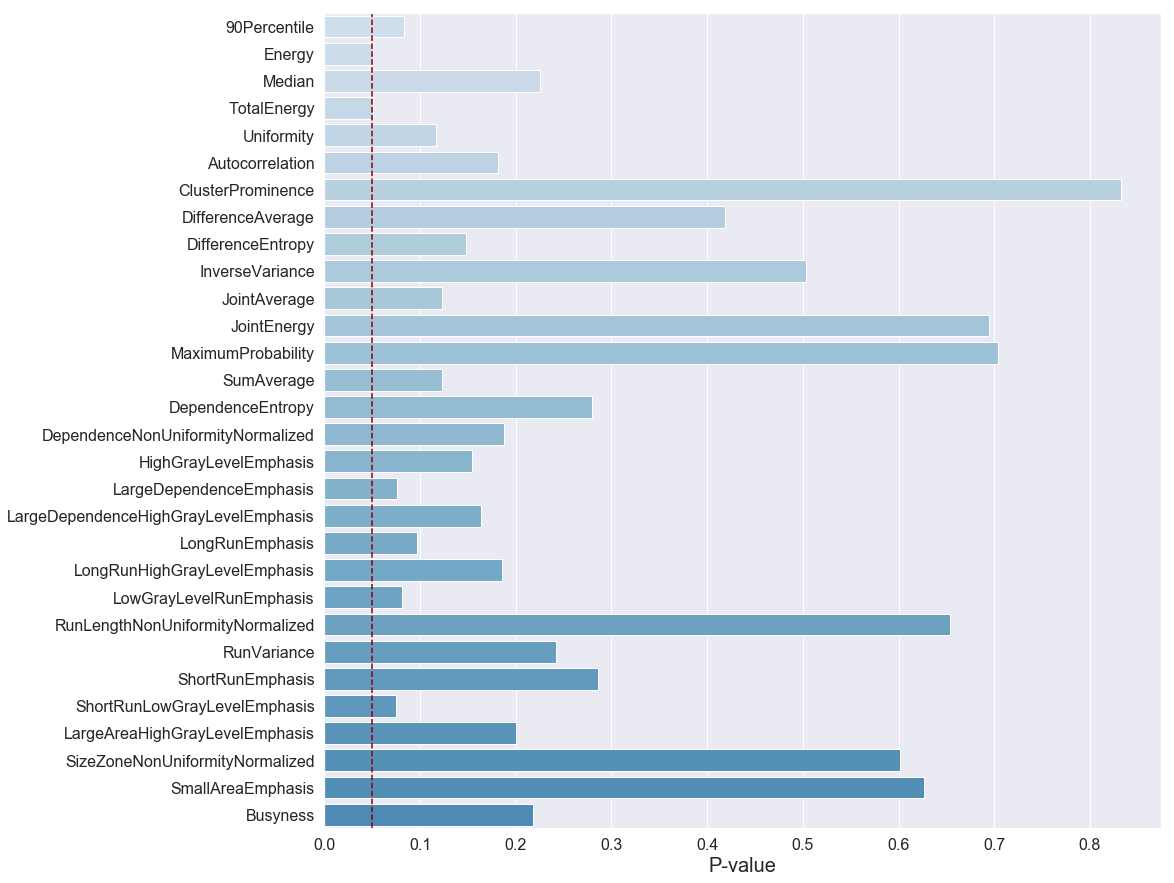

In [205]:
plt.figure(figsize=(15, 15))
fig = sns.barplot(
    y=list(format_feature_labels(CT_same.keys())),
    x=list(CT_same.values()),
    palette=sns.color_palette('Blues', len(CT_same) + 15)[15:],
    ci=None
)
plt.xlabel('P-value', fontsize=20)
plt.xticks(fontsize=16, rotation=0)
plt.yticks(fontsize=16, rotation=0)
plt.axvline(x=0.05, c='darkred', linestyle='--')
plt.savefig(
    './../../figures/removing_damaged_slices/not_diff_ct_feats.png', 
    bbox_inches='tight',
    dpi=100, 
)

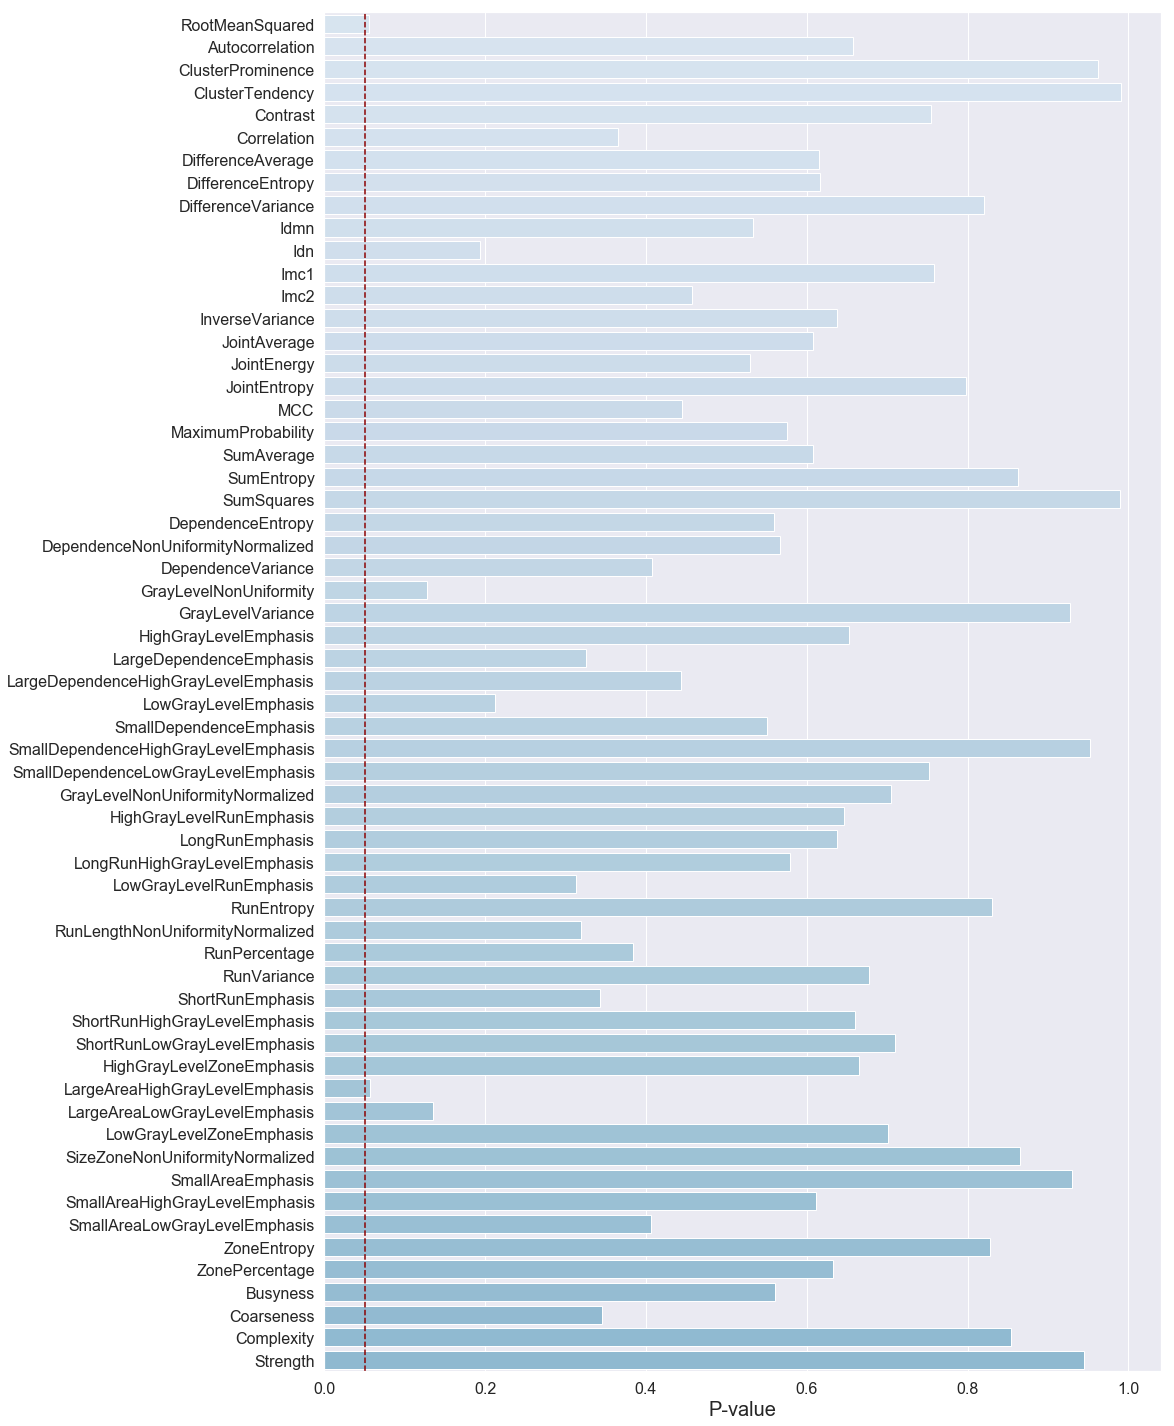

In [206]:
plt.figure(figsize=(15, 25))
fig = sns.barplot(
    y=list(format_feature_labels(PET_same.keys())),
    x=list(PET_same.values()),
    palette=sns.color_palette('Blues', len(PET_same) + 40)[40:],
    ci=None
)
plt.xlabel('P-value', fontsize=20)
plt.xticks(fontsize=16, rotation=0)
plt.yticks(fontsize=16, rotation=0)
plt.axvline(x=0.05, c='darkred', linestyle='--')

plt.savefig(
    './../../figures/removing_damaged_slices/not_diff_pet_feats.png', 
    bbox_inches='tight',
    dpi=100, 
)